In [63]:


import os
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import pdb
import cv2

from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as T

from transformers import SamProcessor
from torch.utils.data import DataLoader
from torch.optim import Adam
import monai
from scipy.ndimage import zoom

from transformers import SamModel 

INPUT_PATCH_SIZE = 1024
num_epochs = 1
image_dir = '../data/data_crop1024_shift512/train_images'
mask_dir = '../data/data_crop1024_shift512/train_mask'
checkpoint_dir = 'checkpoints/'


class SAMDataset(Dataset):
    def __init__(self, img_dir, mask_dir, processor, transform = None):
        self.processor = processor

        # get mask file path list

        self.img_dir = img_dir
        self.mask_dir = mask_dir
        
        self.mask_path_list = os.listdir(mask_dir)
        self.transform = transform
        

    def get_bounding_box(self, ground_truth_map):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        if len(x_indices) == 0:
            return [0,0,INPUT_PATCH_SIZE,INPUT_PATCH_SIZE]
        
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]
        return bbox
    
    def __len__(self):
        return len(self.mask_path_list)
    
    def __getitem__(self, idx):
        # item = self.dataset[idx]
        mask_path = os.path.join(self.mask_dir,self.mask_path_list[idx])
        # mask = Image.open(mask_path)
        # mask = mask.resize((256,256))
        # mask = np.array(mask)
        # mask[mask==2] =  1
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # mask = cv2.resize(mask, (256, 256))
        mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)[1].astype(bool)

        img_path = os.path.join(self.img_dir, self.mask_path_list[idx].replace('_mask',''))
        image = Image.open(img_path)
        # image = item["image"]
        # mask = np.array(item["label"])
    

        if self.transform:
            image, mask = self.transform(image, mask)

        mask = zoom(mask, 256./INPUT_PATCH_SIZE, order=1)  # order=1 for bilinear interpolation

        prompt = self.get_bounding_box(mask)
        
        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
        
        # pdb.set_trace()
        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        
        # add ground truth segmentation
        inputs["ground_truth_mask"] = mask
        
        return inputs

    
# Define transformations for both images and masks using torchvision.transforms.v2 and RandAugment
transform = T.Compose([
    T.RandomResizedCrop((1024, 1024), scale=(0.8, 1.2)),  # Random resized crop
    T.RandomHorizontalFlip(),  # Random horizontal flipping
    T.RandomVerticalFlip(),    # Random vertical flipping
    T.RandomRotation(degrees=(-45, 45)),  # Random rotation
    T.RandomAffine(degrees=0, translate=(0.2, 0.2)),  # Random shifts (adjust translate values as needed)
])
    

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

train_dataset = SAMDataset(img_dir= image_dir, mask_dir= mask_dir, processor=processor, transform = None)

train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True)


# In[5]:



In [64]:

batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([3, 3, 1024, 1024])
original_sizes torch.Size([3, 2])
reshaped_input_sizes torch.Size([3, 2])
input_boxes torch.Size([3, 1, 4])
ground_truth_mask torch.Size([3, 256, 256])


In [65]:
batch['reshaped_input_sizes']

tensor([[1024, 1024],
        [1024, 1024],
        [1024, 1024]])

In [66]:
from matplotlib import pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


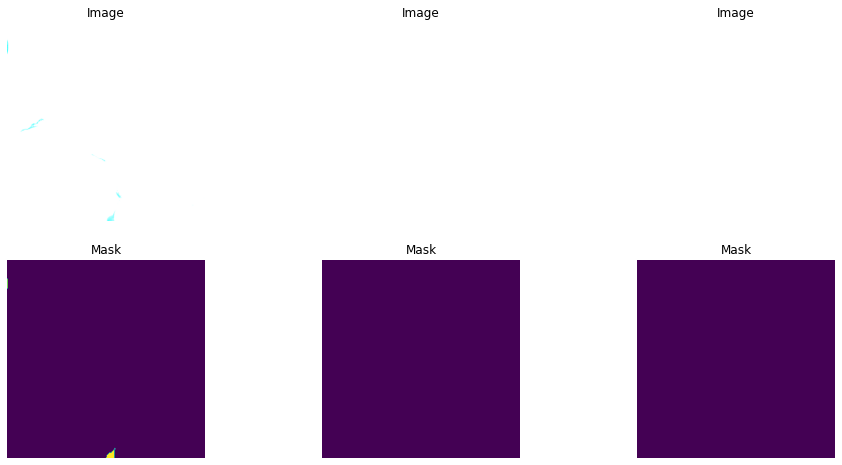

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


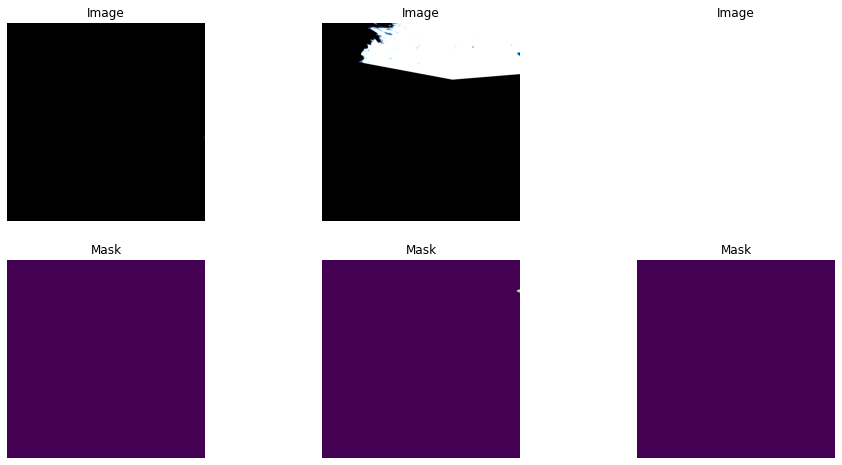

torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


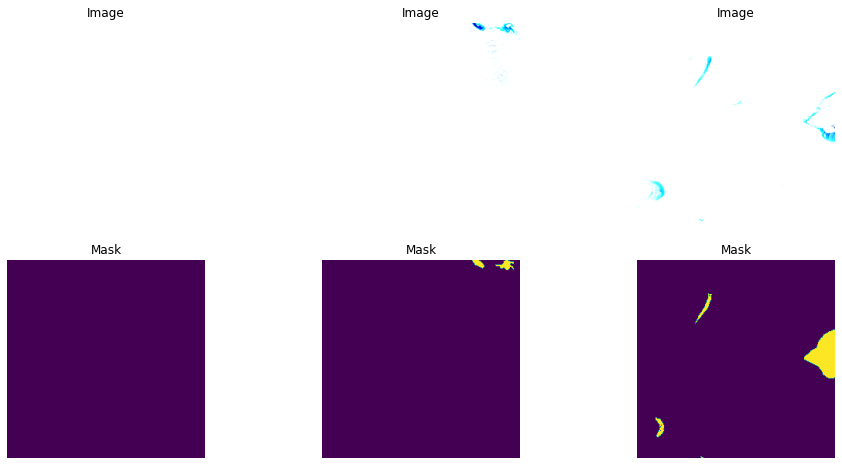

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


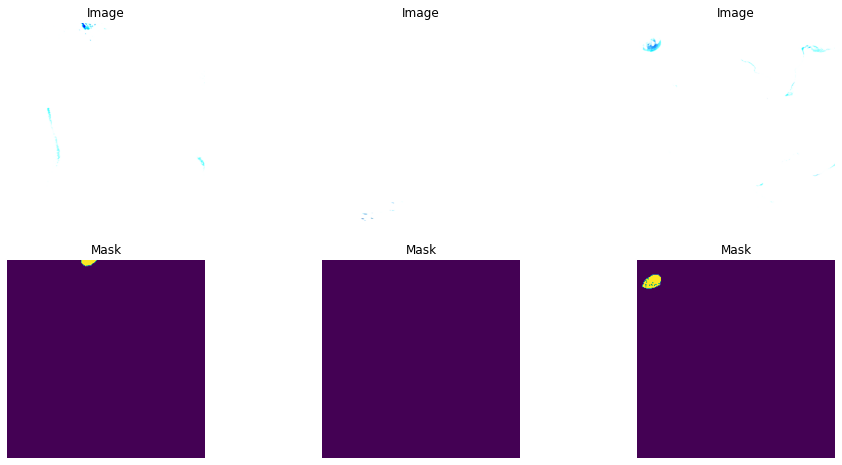

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


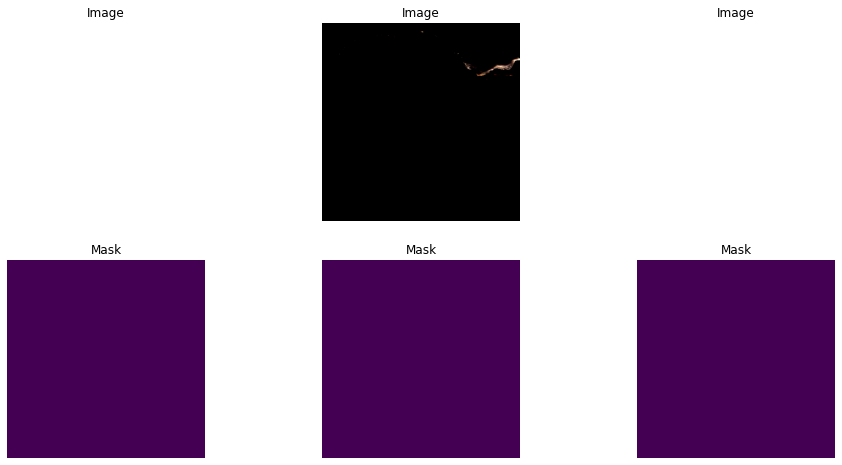

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


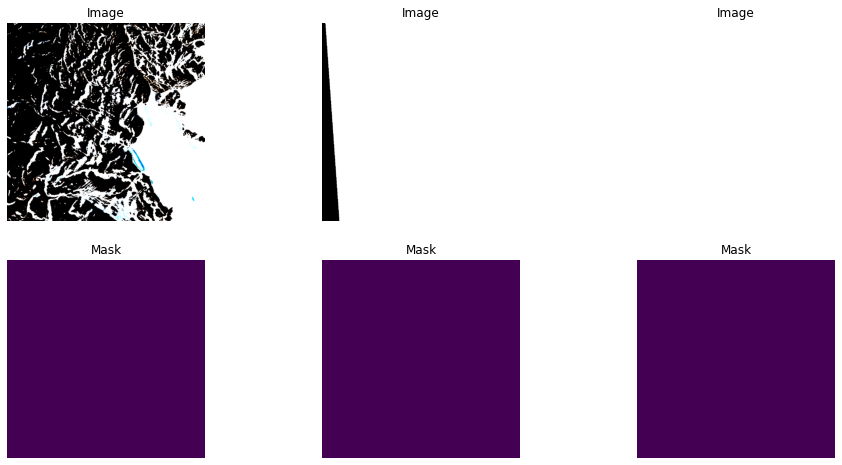

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


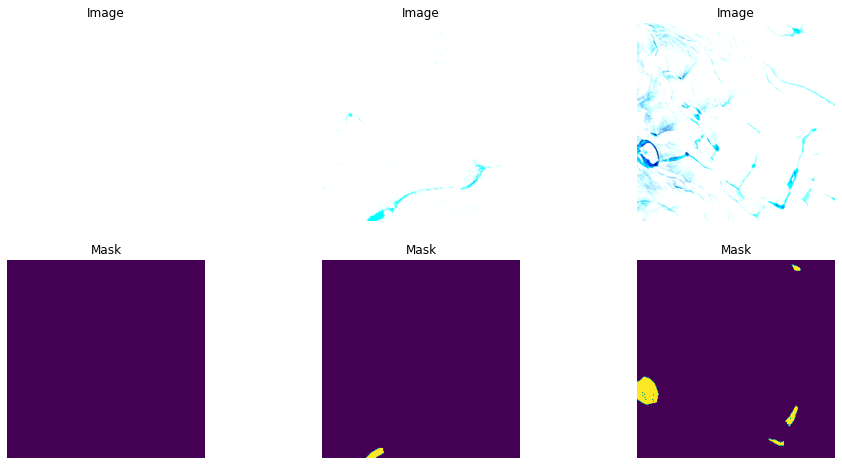

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


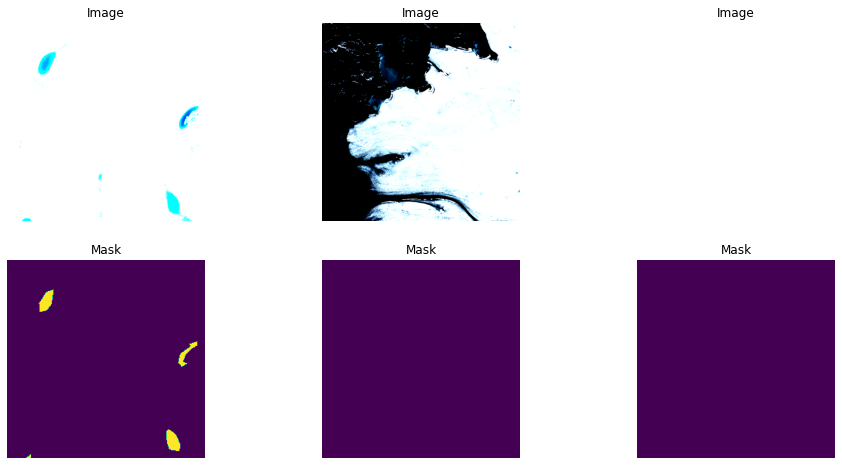

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


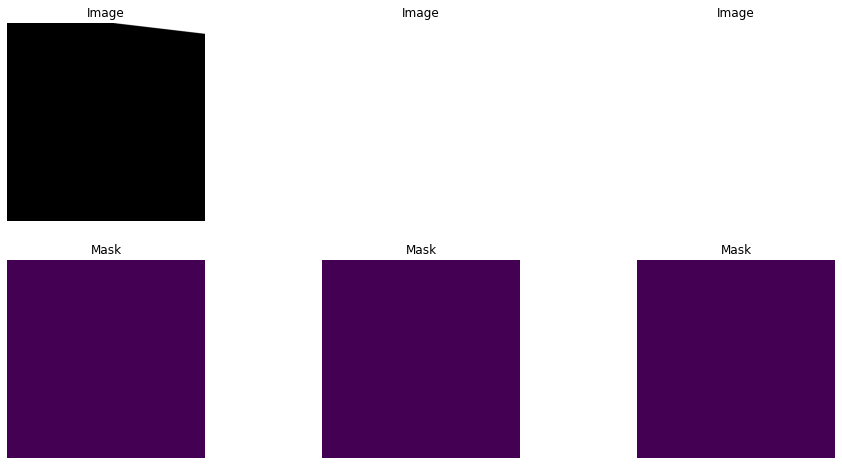

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


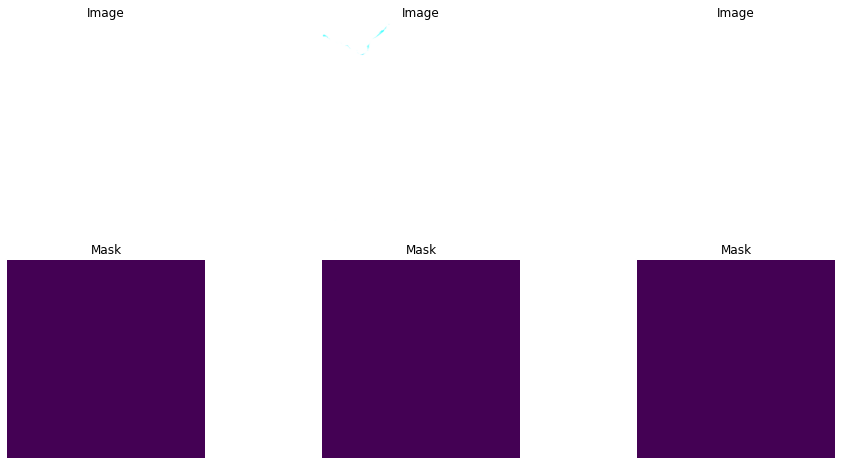

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


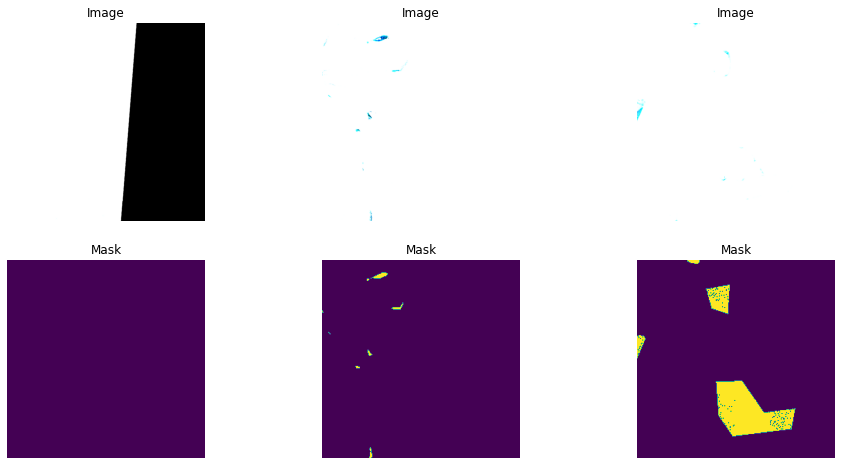

torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


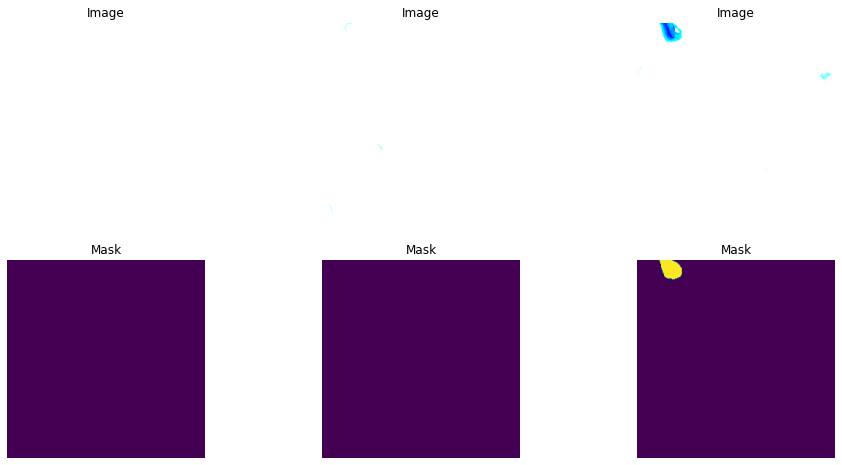

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


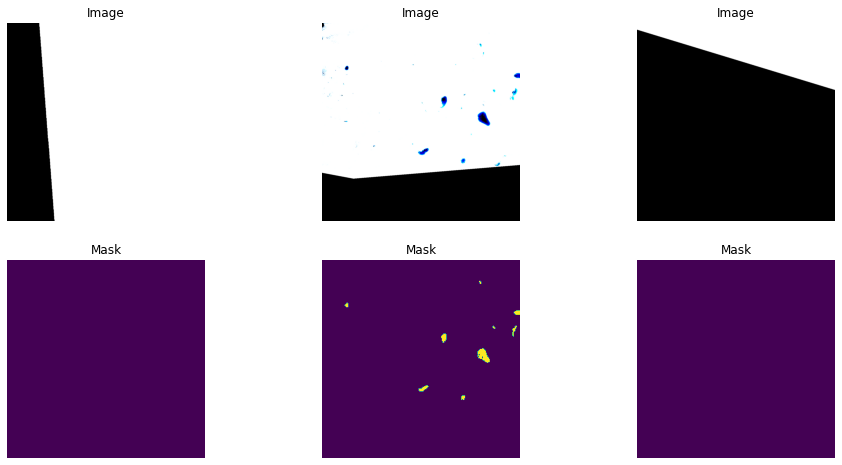

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


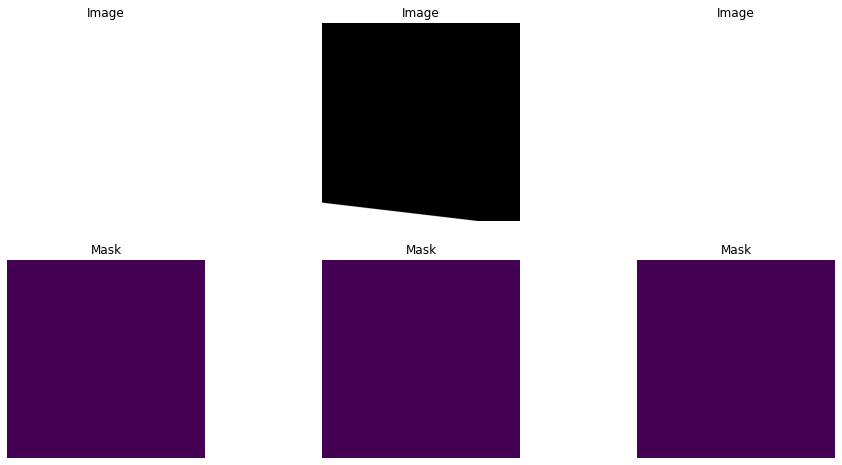

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


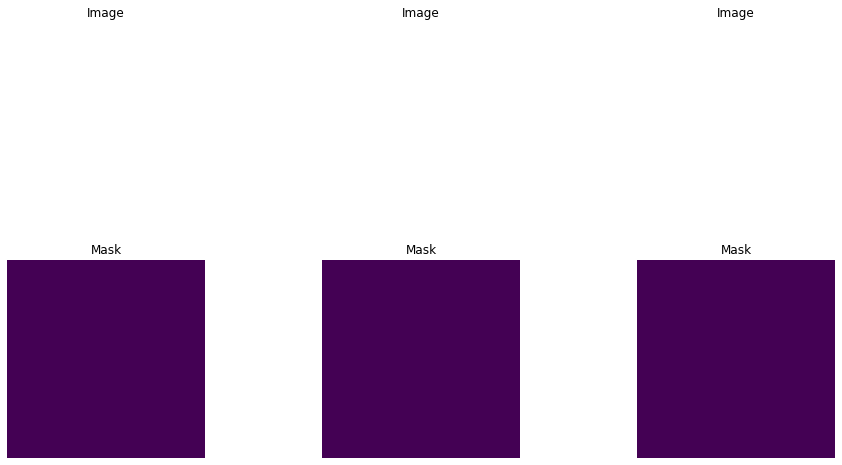

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


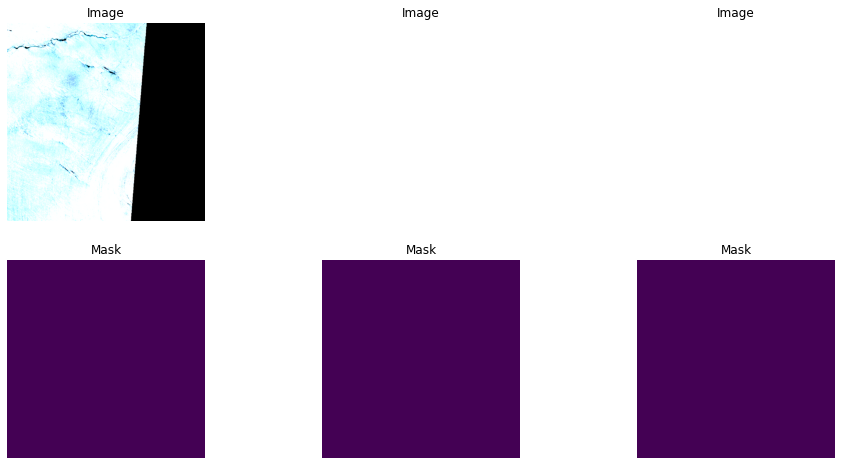

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


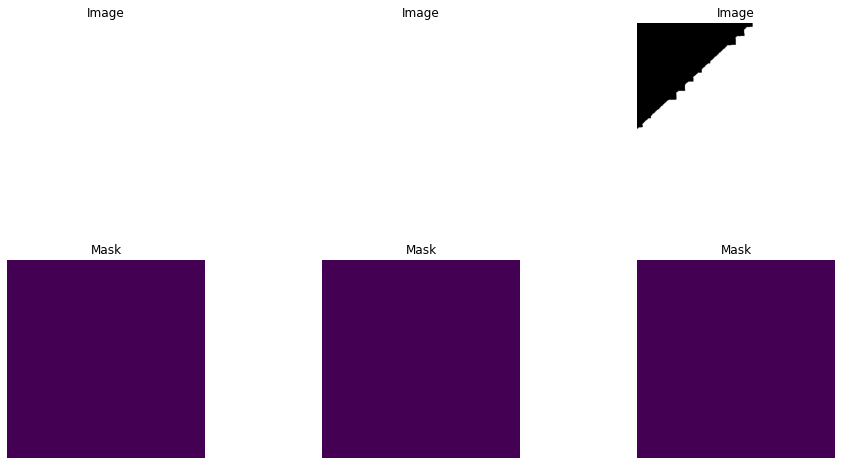

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


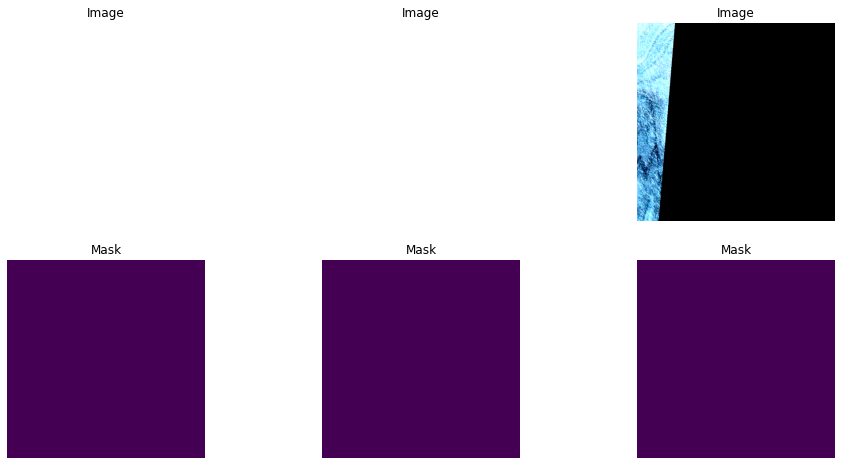

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


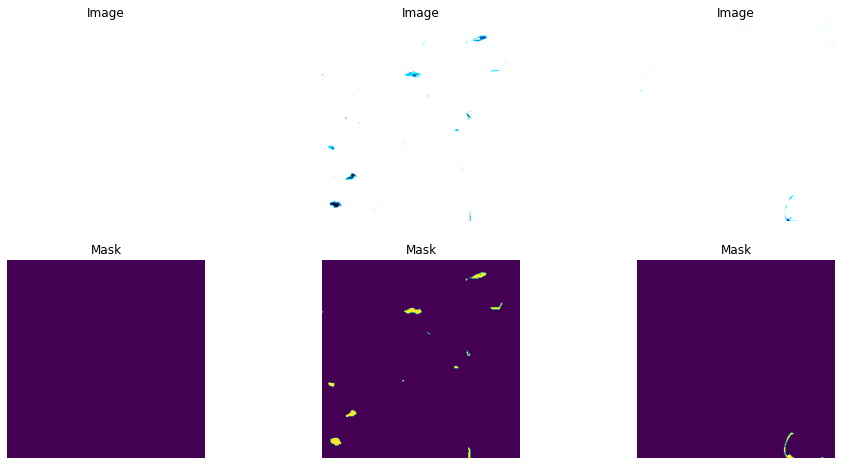

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


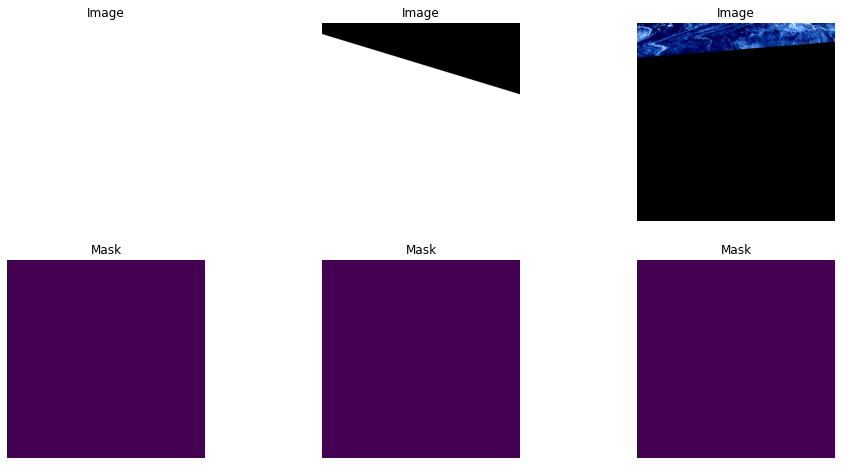

torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


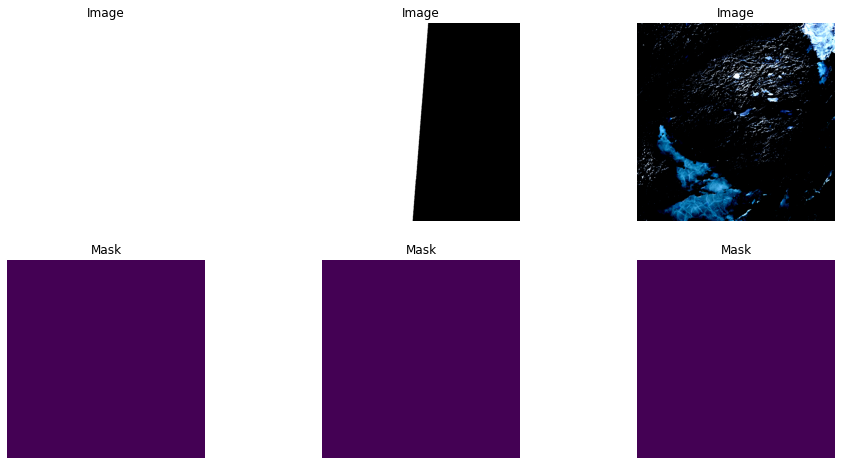

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


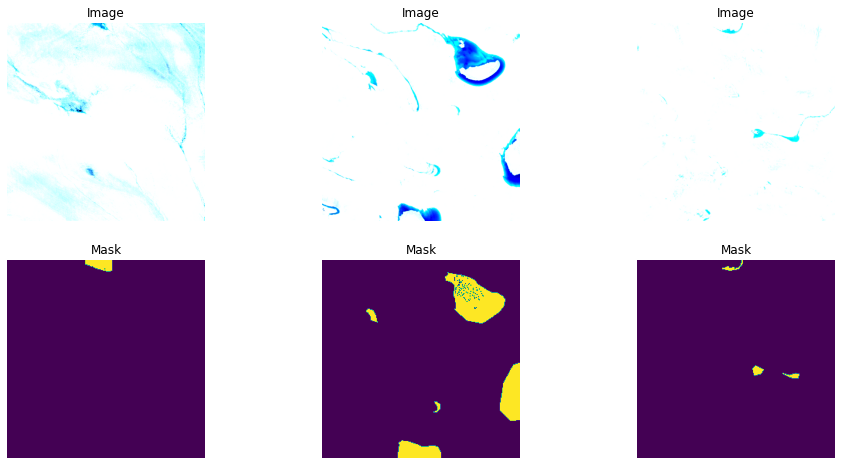

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


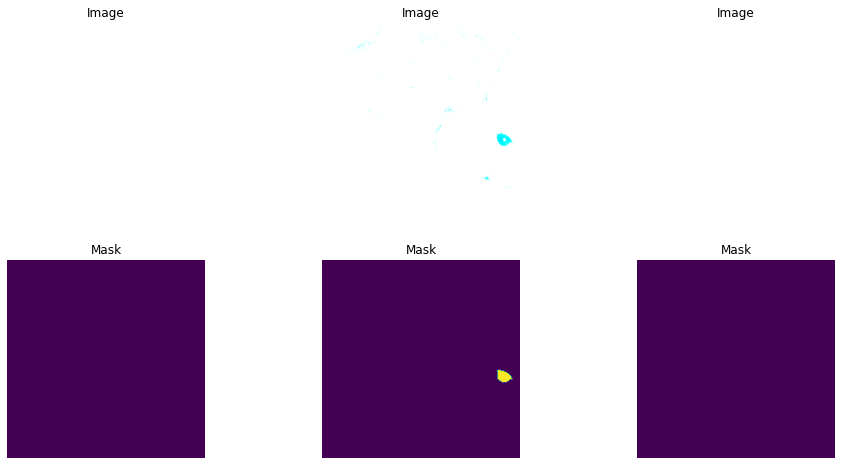

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


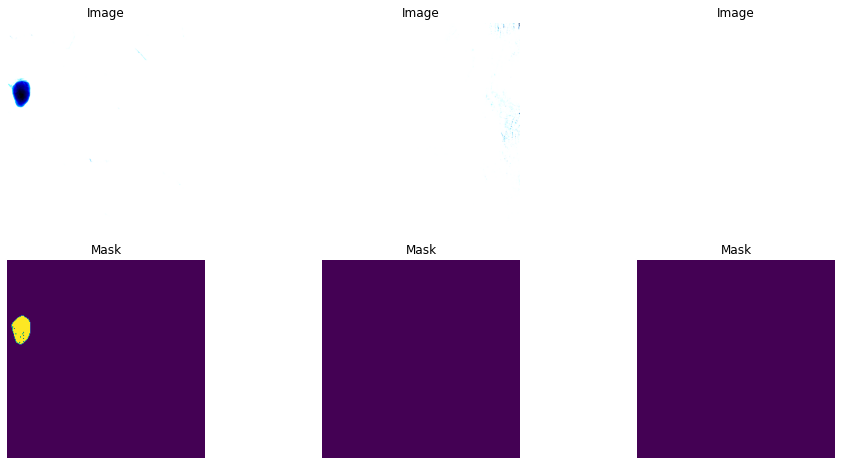

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


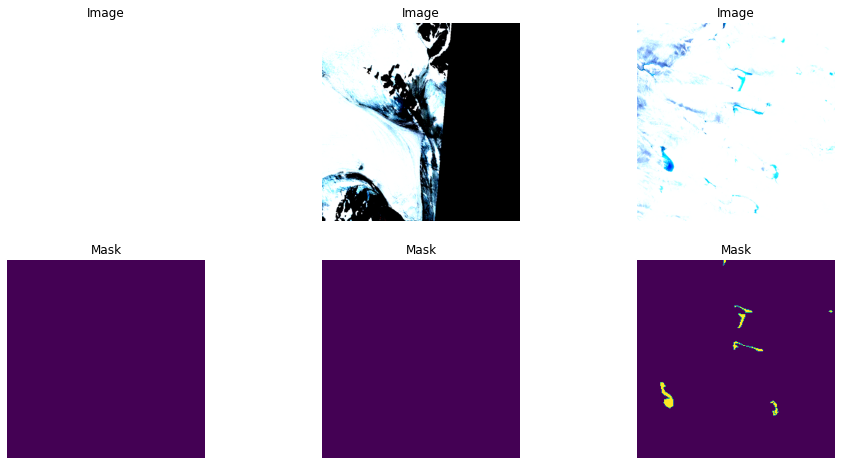

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


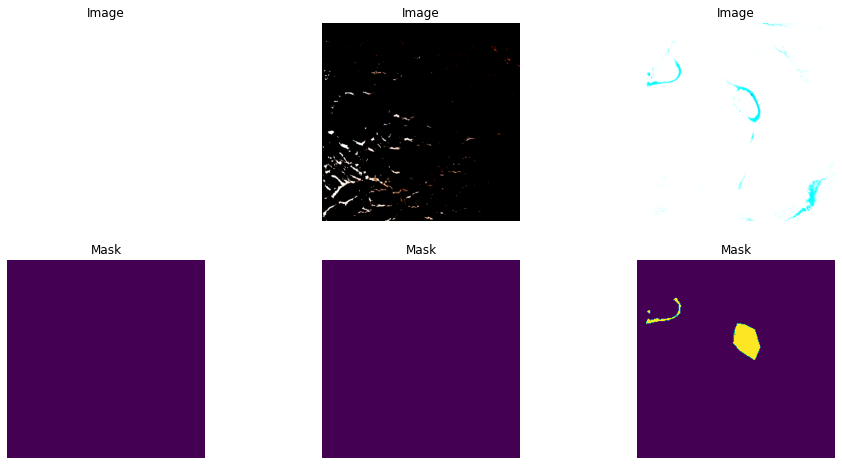

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


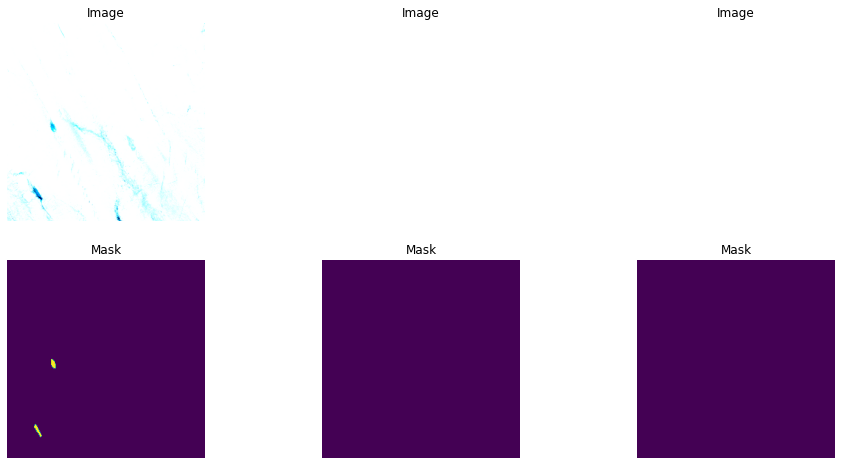

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


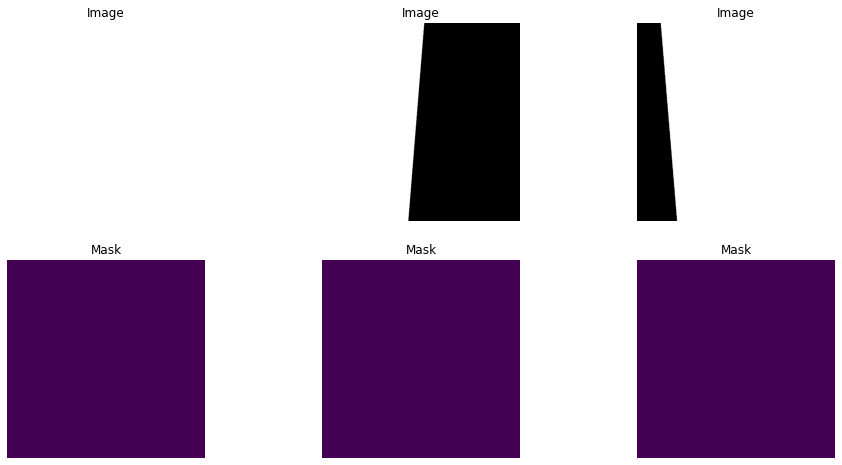

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


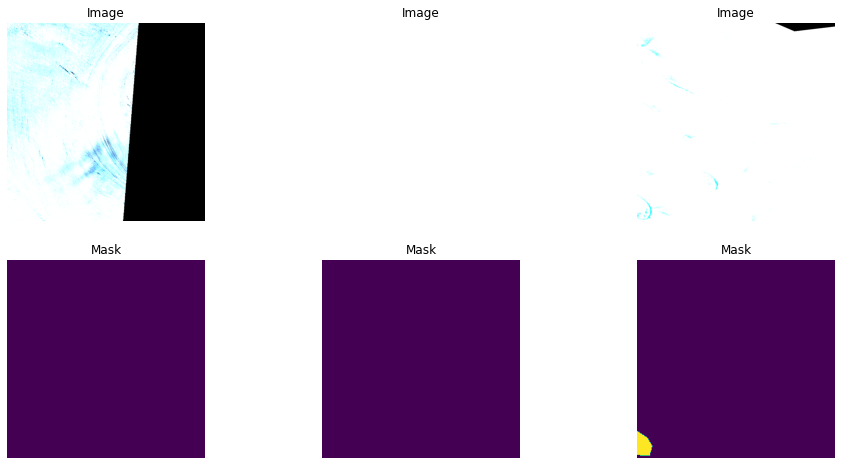

torch.Size([3, 3, 1024, 1024]) torch.Size([3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


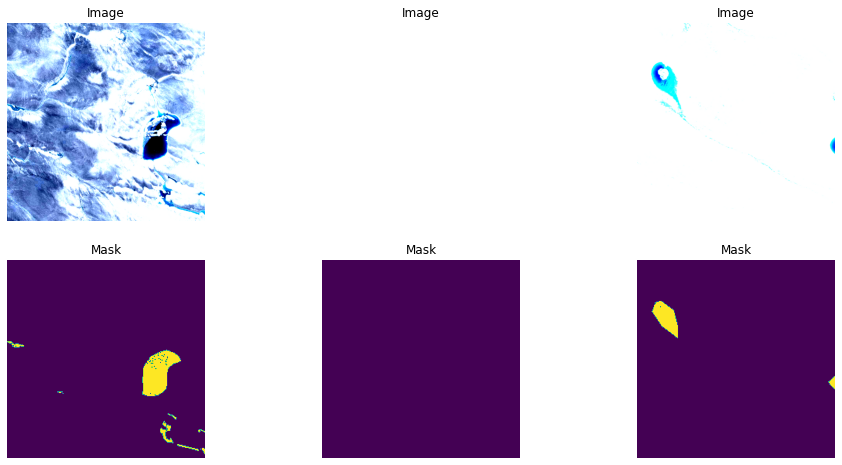

In [67]:
for i in range(0,30):
    # batch = train_dataset[i]
    batch = next(iter(train_dataloader))
    pixel_values = batch['pixel_values']

    input_boxes = batch['input_boxes']
    ground_truth_mask = batch['ground_truth_mask']
    print(pixel_values.shape, ground_truth_mask.shape)
    # masks = ground_truth_mask.copy()

    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    for j in range(0,3):

        # Display images
        axes[0][j].imshow(pixel_values[j].permute(1, 2, 0)) # .cpu().numpy())
        axes[0][j].set_title('Image')
        axes[0][j].axis('off')
        
        # Display masks
        axes[1][j].imshow(np.expand_dims(ground_truth_mask[j],2))# .permute(1, 2, 0).cpu().numpy())
        axes[1][j].set_title('Mask')
        axes[1][j].axis('off')

    plt.show()